In [28]:
library(ggplot2)
library(data.table)
library(zoo)
library(plyr)
library(pls)
library(stringr)

In [131]:
# Load Raw Data
data <- fread('db_data.csv')
head(data)
dim(data)

stock,date,fwd_returns,F01,F02,F03,F04,F05,F06,F07,...,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20
S000,D000,NA,NA,NA,NA,NA,NA,NA,NA,...,1,NA,NA,NA,NA,NA,NA,NA,NA,0
S000,D001,NA,NA,NA,NA,NA,NA,NA,NA,...,1,NA,NA,NA,NA,NA,NA,NA,NA,0
S000,D002,NA,NA,NA,NA,NA,NA,NA,NA,...,1,NA,NA,NA,NA,NA,NA,NA,NA,0
S000,D003,NA,NA,NA,NA,NA,NA,NA,NA,...,1,NA,NA,NA,NA,NA,NA,NA,NA,0
S000,D004,NA,NA,NA,NA,NA,NA,NA,NA,...,1,NA,NA,NA,NA,NA,NA,NA,NA,0
S000,D005,NA,NA,NA,NA,NA,NA,NA,NA,...,1,NA,NA,NA,NA,NA,NA,NA,NA,0


[1] 87720    23

In [132]:
## Deal with NAs in the dependent variable
# Since this dataset is special in the sense that its NAs in the dependent variable are all consecutive,
# I simply drop the observations with NA dependent variable.
# Otherwise, we should consider to fill the NAs with the market or sector mean (or median) on that particular trading day
# (especially when moving average of the past dependent variable values will be used as predictors). 
data <- data[! is.na(fwd_returns)]
head(data)
dim(data)

stock,date,fwd_returns,F01,F02,F03,F04,F05,F06,F07,...,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20
S000,D095,2.197040,NA,NA,NA,NA,NA,NA,NA,...,1,-1.793722,NA,0.0000000,NA,6.241404,NA,NA,NA,1665.7
S000,D096,11.676850,2.099986,0,NA,NA,NA,2.197040,NA,...,2,-242.105263,NA,0.0000000,1.7651052,2.824254,NA,NA,NA,1641.7
S000,D097,10.131712,2.345198,0,NA,NA,NA,11.676850,NA,...,2,-242.105263,NA,0.0000000,1.5805471,2.528952,NA,NA,NA,1641.7
S000,D098,-3.863845,2.541321,0,5228.470,NA,NA,13.750523,NA,...,4,-81.355932,NA,0.0000000,0.5519779,1.422715,0.04948238,2.324622,2.372770,1555.8
S000,D099,-5.405405,2.439388,0,5009.833,NA,NA,-4.011040,NA,...,3,-81.355932,NA,0.1533448,0.5750431,1.482165,0.06066791,2.200884,2.368552,1524.7
S000,D100,6.160081,2.307529,0,4739.031,NA,NA,-5.405405,NA,...,3,-81.355932,NA,0.1621074,0.6079027,1.566860,0.06627076,2.326074,2.368552,1524.7


[1] 74855    23

In [133]:
data <- data[order(stock,date),]
data_cnt <- data[, .N, by = date]
data_cnt[order(date),] # See if there are enough observations on each date

date,N
D000,673
D001,675
D002,677
D003,678
D004,675
D005,676
D006,672
D007,671
D008,673
D009,672


  fwd_returns           F01                F02             F03        
 Min.   :-98.664   Min.   :  0.0001   Min.   :0.000   Min.   :     0  
 1st Qu.: -3.884   1st Qu.:  0.8650   1st Qu.:2.000   1st Qu.:  4887  
 Median :  1.042   Median :  1.5891   Median :3.000   Median :  9986  
 Mean   :  1.022   Mean   :  2.3780   Mean   :3.775   Mean   : 23067  
 3rd Qu.:  5.793   3rd Qu.:  2.8376   3rd Qu.:5.000   3rd Qu.: 21261  
 Max.   :396.325   Max.   :238.6016   Max.   :9.000   Max.   :818750  
                   NA's   :606        NA's   :202     NA's   :439     
      F04                F05                F06                F07           
 Min.   :   0.000   Min.   :-523.249   Min.   :-98.6638   Min.   :    0.000  
 1st Qu.:   1.606   1st Qu.:  -6.963   1st Qu.: -4.0685   1st Qu.:    0.276  
 Median :   2.604   Median :  11.280   Median :  0.8978   Median :    0.597  
 Mean   :   4.608   Mean   :  13.755   Mean   :  0.9410   Mean   :    3.084  
 3rd Qu.:   4.232   3rd Qu.:  29.581   3rd

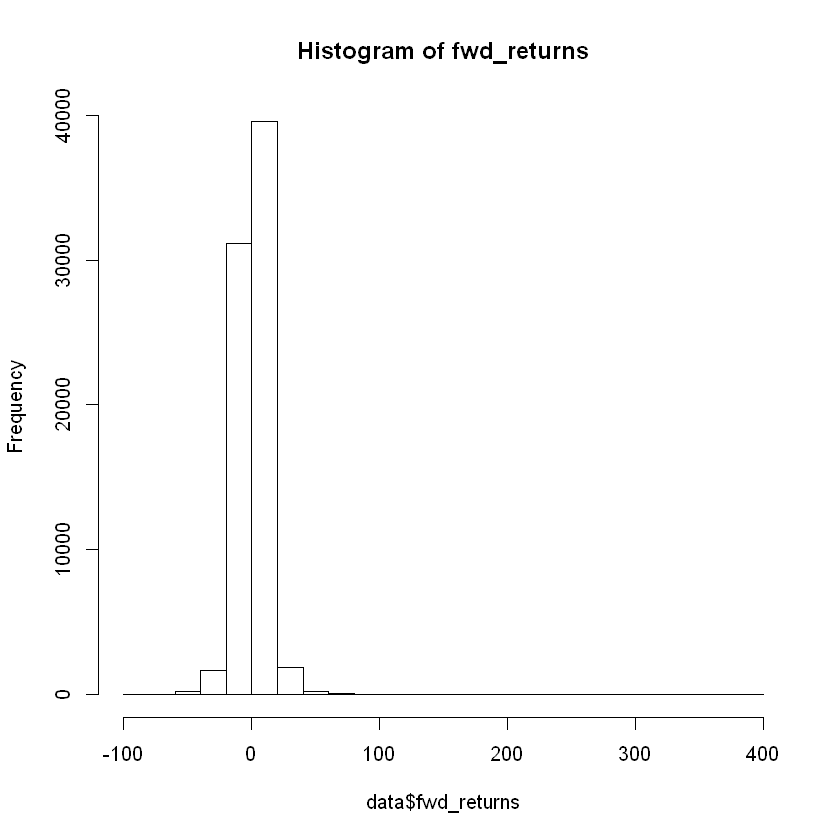

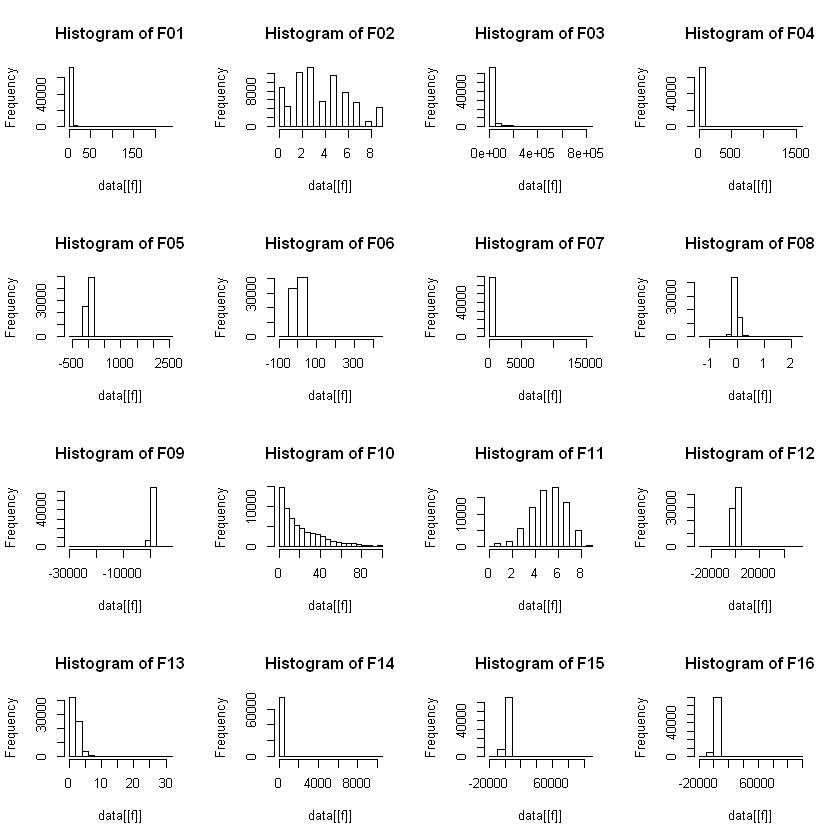

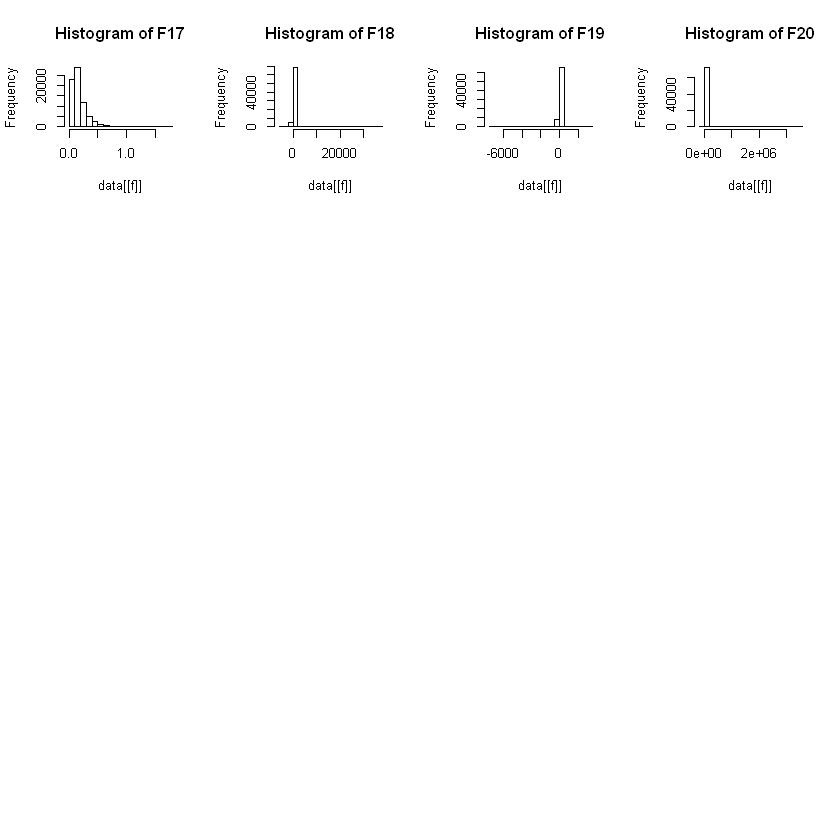

In [134]:
## Function to view the basic statistics and histograms of the variables
view_data <- function(data){
    ## Summary statics
    print(summary(data[,3:23]))
    
    ## Histograms
    # Dependent variable
    hist(data$fwd_returns, main ="Histogram of fwd_returns")

    # Independent variables
    # List contains names of independent variables
    factor_str_list = c()
    for (i in c(1:20)) {
        factor_str_list = c(factor_str_list, paste('F', str_pad(as.character(i), 2, side = 'left', pad = '0'), sep=''))
    }

    par(mfrow = c(4,4))
    for (f in factor_str_list){
        hist(data[[f]], main = paste("Histogram of ", f, sep='')) # Some histograms look weird due to outliers
    }
    par(mfrow = c(1,1))
}

# View data before winsorization
view_data(data)

In [135]:
## Winsorize data
# Function to winsorize on both sides
winsorize <- function(var, probs = c(0.01, 0.99), na.rm = TRUE){
    bound <- quantile(var, probs = probs, na.rm = TRUE)
    var[var < bound[1]] <- bound[1]
    var[var > bound[2]] <- bound[2]
    var
}
# winsorize: probs selceted is for each variable so that there is no gap between bins in its histogram
for (i in c(3:4, 6:13, 15:23)){
    if (i ==3) {data[[i]] = winsorize(data[[i]], probs = c(0.01, 0.99),  na.rm = TRUE)}
    else {data[[i]] = winsorize(data[[i]], probs = c(0.05, 0.95),  na.rm = TRUE)}
}

# Output as data_winsorized_withoutNAreplace.csv
#fwrite(data, "data_winsorized_withoutNAreplace.csv")

  fwd_returns            F01              F02             F03       
 Min.   :-28.2596   Min.   :0.2681   Min.   :0.000   Min.   : 1703  
 1st Qu.: -3.8840   1st Qu.:0.8650   1st Qu.:2.000   1st Qu.: 4887  
 Median :  1.0417   Median :1.5891   Median :3.000   Median : 9986  
 Mean   :  0.9219   Mean   :2.1758   Mean   :3.775   Mean   :18630  
 3rd Qu.:  5.7935   3rd Qu.:2.8376   3rd Qu.:5.000   3rd Qu.:21260  
 Max.   : 30.8352   Max.   :7.1494   Max.   :9.000   Max.   :90166  
                    NA's   :606      NA's   :202     NA's   :439    
      F04               F05               F06                F07       
 Min.   : 0.8247   Min.   :-43.738   Min.   :-14.6490   Min.   :0.000  
 1st Qu.: 1.6057   1st Qu.: -6.963   1st Qu.: -4.0685   1st Qu.:0.276  
 Median : 2.6042   Median : 11.280   Median :  0.8978   Median :0.597  
 Mean   : 3.3747   Mean   : 11.837   Mean   :  0.7849   Mean   :0.956  
 3rd Qu.: 4.2322   3rd Qu.: 29.581   3rd Qu.:  5.6170   3rd Qu.:1.197  
 Max.   :10.3306

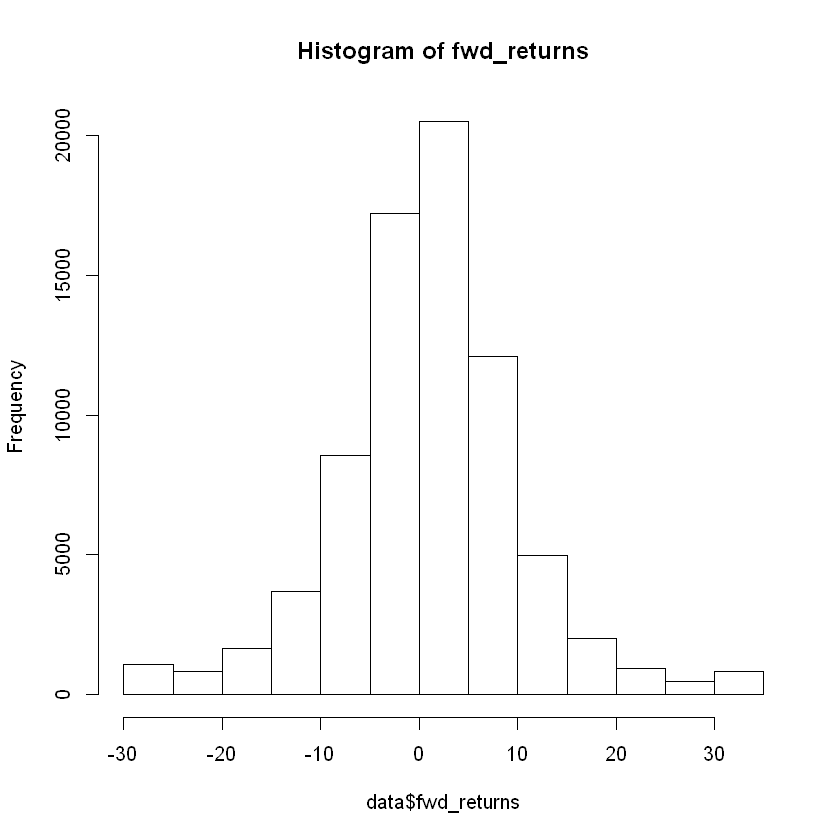

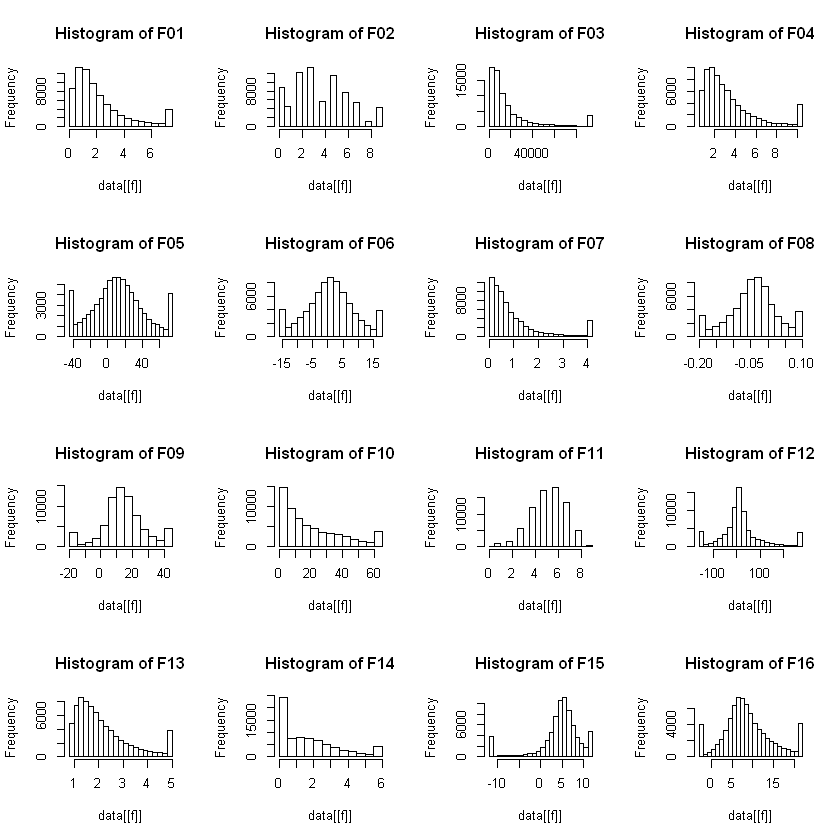

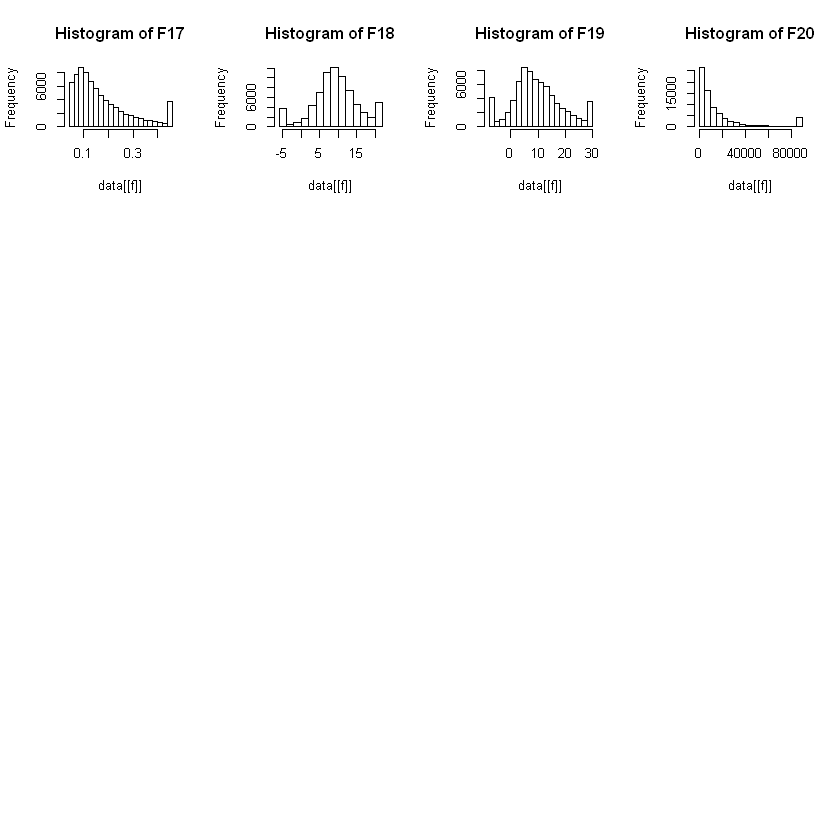

In [144]:
# View the data again after winsorization
view_data(data)

In [145]:
## Deal with NAs in the independent variables

# change the variable type of F02 from integer to numeric
data[,F02 := as.numeric(F02)]

# Replace NAs with median values
for (i in c(1:20)) {
    factor_string = factor_str_list[i]
    data[['x']] = data[[factor_string]]
    # for both continuous and categorical x variables, replace NAs with the sector median value on each given date;
    # if the sector classification is unknown (F02 is NA), then replace NAs with market median value on each given date
    if (i != 2) {
        data[, mktmedian := median(x, na.rm = TRUE), by = date]
        data[, x := ifelse(is.na(x), ifelse(is.na(F02), mktmedian, median(x, na.rm = TRUE)), x), by = list(date, F02)]}
    # for the sector classification variable F02, it only has a market median
    else {data[,x := ifelse(is.na(x), median(x, na.rm = TRUE), x), by = date]}
    data[[factor_string]] = data[['x']]
}

# Remove useless columns
data[, ":="(
    'x' = NULL,
    'mktmedian' = NULL),]

Warning message in `[.data.table`(data, , `:=`(mktmedian, median(x, na.rm = TRUE)), :
"Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or been created manually using structure() or similar). Avoid key<-, names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. Also, in R<=v3.0.2, list(DT1,DT2) copied the entire DT1 and DT2 (R's list() used to copy named objects); please upgrade to R>v3.0.2 if that is biting. If this message doesn't help, please report to datatable-help so the root cause can be fixed."

  fwd_returns            F01              F02             F03       
 Min.   :-28.2596   Min.   :0.2681   Min.   :0.000   Min.   : 1703  
 1st Qu.: -3.8840   1st Qu.:0.8699   1st Qu.:2.000   1st Qu.: 4904  
 Median :  1.0417   Median :1.5868   Median :3.000   Median : 9963  
 Mean   :  0.9219   Mean   :2.1722   Mean   :3.773   Mean   :18578  
 3rd Qu.:  5.7935   3rd Qu.:2.8271   3rd Qu.:5.000   3rd Qu.:21136  
 Max.   : 30.8352   Max.   :7.1494   Max.   :9.000   Max.   :90166  
      F04               F05               F06                F07        
 Min.   : 0.8247   Min.   :-43.738   Min.   :-14.6490   Min.   :0.0000  
 1st Qu.: 1.6190   1st Qu.: -6.845   1st Qu.: -4.0670   1st Qu.:0.2882  
 Median : 2.6321   Median : 11.305   Median :  0.8979   Median :0.6083  
 Mean   : 3.3575   Mean   : 11.831   Mean   :  0.7844   Mean   :0.9405  
 3rd Qu.: 4.1635   3rd Qu.: 29.466   3rd Qu.:  5.6145   3rd Qu.:1.1679  
 Max.   :10.3306   Max.   : 73.518   Max.   : 16.2793   Max.   :4.1583  
      

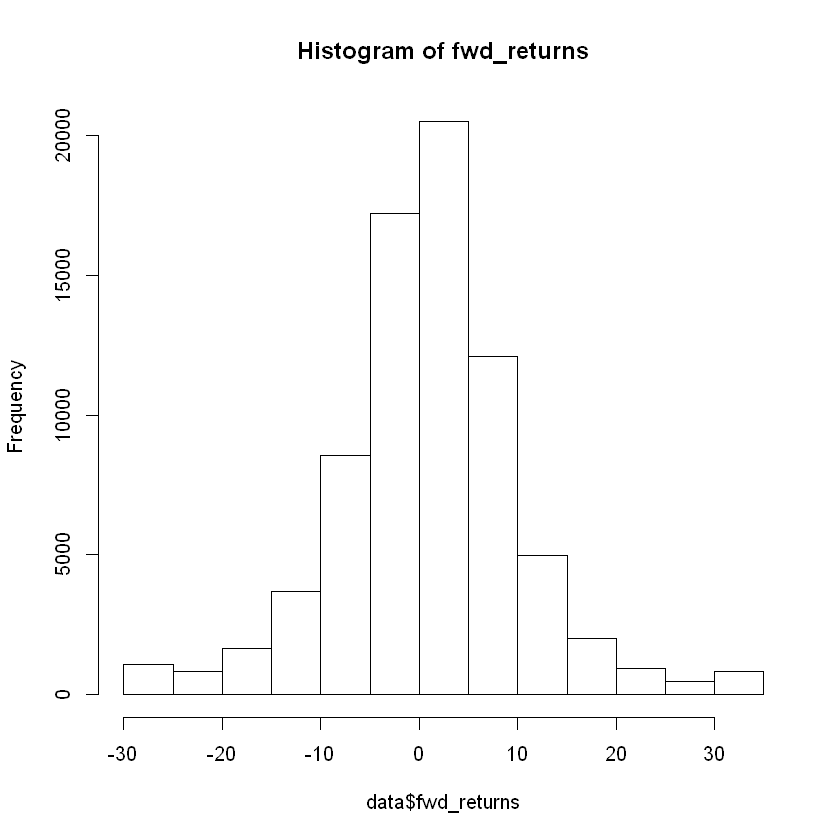

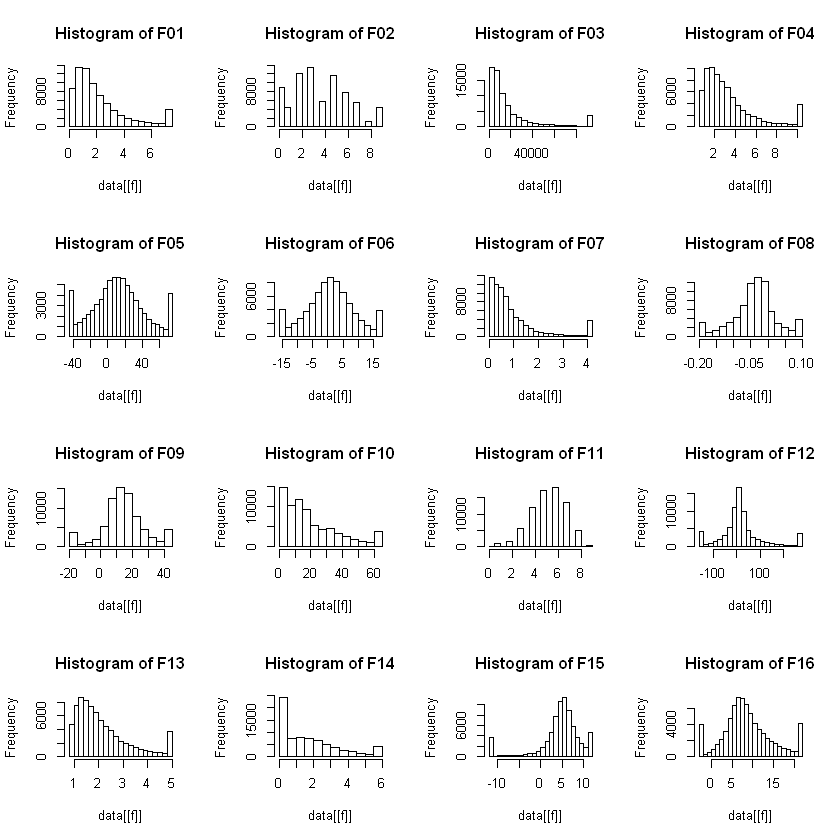

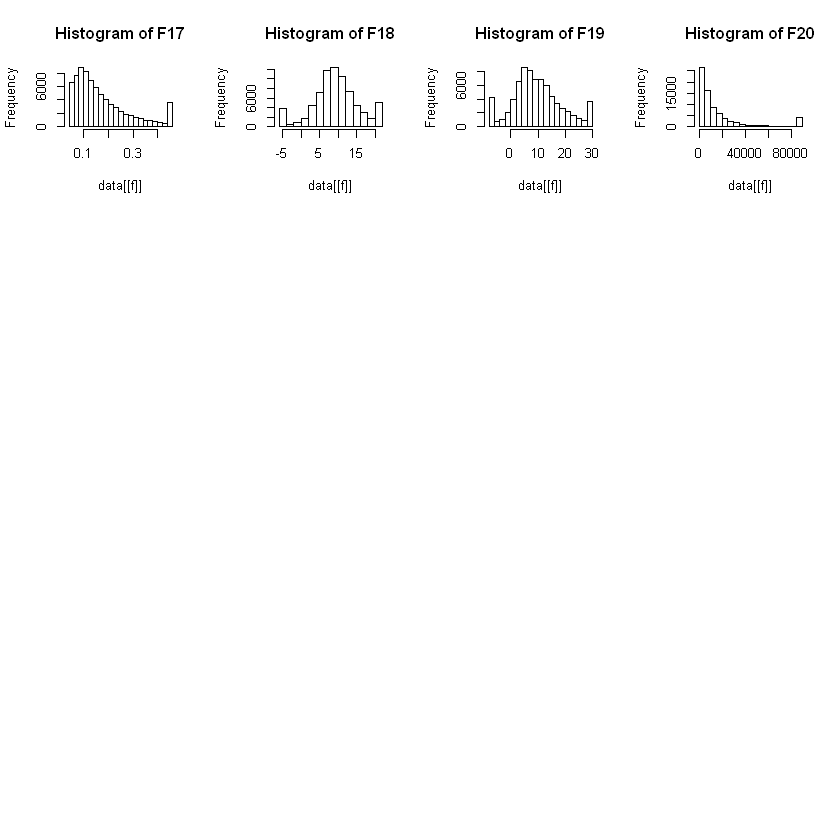

In [149]:
view_data(data)

In [153]:
# Output data_winsorized_NAreplaced
fwrite(data, "data_winsorized_NAreplaced.csv")

In [158]:
for (i in c(1:20)) {
    factor_string = factor_str_list[i]
    data[['x']] = data[[factor_string]]
    print(factor_string)
    print(summary(lm(fwd_returns ~ x, data)))
}

[1] "F01"

Call:
lm(formula = fwd_returns ~ x, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-29.2103  -4.8058   0.1203   4.8664  29.9884 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.95469    0.05318  17.952   <2e-16 ***
x           -0.01509    0.01877  -0.804    0.421    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.34 on 74853 degrees of freedom
Multiple R-squared:  8.633e-06,	Adjusted R-squared:  -4.726e-06 
F-statistic: 0.6462 on 1 and 74853 DF,  p-value: 0.4215

[1] "F02"

Call:
lm(formula = fwd_returns ~ x, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-29.2860  -4.8098   0.1152   4.8655  29.9887 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.84652    0.06222  13.604   <2e-16 ***
x            0.01998    0.01379   1.449    0.147    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual